# Gradient Descent

Gradient Descent is a powerful tool used in machine learning. It is a method of unconstrained optimisation to minimise a multivariate differentiable function. The idea is to take repeated steps in the opposite direction of the gradient of the function at the current point. At a point, the steps are given the form:



where a is the current point, ita is the learning rate, and grad(f) is the gradient of the function. The step size is determined by the learning rate and the gradient of the function at that point, meaning a large gradient or learning rate will give a large step. As the points settle at the minima, the steps decrease until it reaches a tolerable spot.

In this project, I use a stochastic gradient descent (SGD) method, which only uses a simple sample instead of all samples in the data, to perform the descent. I built my own descent function from scratch and compared it against the built-in SGD within scikitlearn. After that, I used the parameters found by my version and the built-in version to train two models using the breast cancer data from scikitlearn and see how they perform.

### Assumptions

- The loss function is differentiable with respect to the model parameters.
- Gradients are informative of the local geometry of the loss surface.
- A suitable learning rate exists that ensures convergence.
- Features are appropriately scaled so that gradients are not dominated by a single dimension.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (accuracy_score, precision_recall_curve, precision_recall_fscore_support,
                             roc_auc_score, log_loss, brier_score_loss, confusion_matrix)

from scipy.special import expit

np.set_printoptions(suppress=True, precision=6)
plt.rcParams['figure.dpi'] = 300

In [2]:
data = load_breast_cancer()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    data.data, data.target, test_size=0.2, random_state=42, stratify=data.target
)

# Validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full
)

# Scale the data
mu = X_train.mean(0)
std = X_train.std(0) + 1e-12

X_train = (X_train - mu)/std
X_val = (X_val -  mu)/std
X_test = (X_test - mu)/std

# Seeds and initilisation
rng = np.random.default_rng(126)
w0 = rng.random(30)
b0 = rng.random()

# Hyperparameters
L2 = 1e-3
learning_rate = 1.4e-1

# Training state
w, b = w0.copy(), float(b0)
best_val = float('inf')
wait = 0
best_w = np.zeros(X_train.shape[1])
best_b = 0.0

#Training Schedule
max_steps = 35
eval_every = 5
stop = 5e-4
patience = 20

In [3]:
def scores(dataset, weights, intercept):
    """
    Linear scores z = (dataset @ weights) + intercept.
    """
    
    return (dataset @ weights) + intercept


def sigmoid(dataset, weights, intercept):
    """
    Calculates P(y=1|x) using sigmoid#
    """
    
    return expit(scores(dataset, weights, intercept))


def evaluate(y_true, y_pred, y_proba, name):
    """
    Print a compact evaluation report for a binary classifier (in this case Logistic Regression
    for the homemade function and SGDClassifier for the scikit-learn function).

    Computes:
    - Accuracy
    - Precision, Recall, F1 (Binary, zero_division=0)
    - AUROC (using probabilities)
    - Log Loss
    - Brier Score (calibration)
    - Confusion Matrix
    """
    
    y_proba = np.clip(y_proba, 1e-15, 1-1e-15)   # Stable log-loss
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    auroc = roc_auc_score(y_true, y_proba)
    ll    = log_loss(y_true, y_proba)
    bs    = brier_score_loss(y_true, y_proba)
    cm    = confusion_matrix(y_true, y_pred)
    print(f"\n{name}")
    print(f"accuracy  : {acc:.4f}")
    print(f"precision : {prec:.4f}   recall: {rec:.4f}   f1: {f1:.4f}")
    print(f"AUROC     : {auroc:.4f}")
    print(f"log loss  : {ll:.4f}")
    print(f"brier: {bs:.4f}")
    print("confusion :\n", cm)


def best_threshold_f1(y_true, scores):
    """
    Choose the probability threshold that maximises F1 on a validation set.
    """
    
    precision, recall, threshold = precision_recall_curve(y_true, scores)
    f1 = (2 * precision * recall) / (precision + recall + 1e-12)
    
    if len(threshold) == 0: # Degenerate case
        return 0.5, float(f1[-1])
    idx = int(np.nanargmax(f1[1:]))   # Align thresholds with f1[1:]
    
    return float(threshold[idx]), float(f1[1:][idx])


def analytic_gradient(dataset, true_value, weights, intercept, L2):
    """
    Calculates gradients that the homemade GD/SGD code should be using.

    Used for calculating the finite-difference gradient check to see if it's following the correct steps.
    """
    
    p = sigmoid(dataset, weights, intercept)
    residual = p - true_value
    gw = (dataset.T @ residual) / (dataset.shape[0] + L2 * weights)      # matches your batch logic
    gb = residual.mean()
    
    return gw, gb


def gradient_check(dataset, true_value, weights, intercept, L2, epsilon=1e-6, atol=1e-8, rtol=1e-5, verbose=True):
    """
    Central-difference check of partial_d(J)/partial_d(w) and partial_d(J)/partial_d(b) against the analytical gradients.
    """
    
    gw, gb = analytic_gradient(dataset, true_value, weights, intercept, L2)

    # Numerical (coordinate-wise central difference)
    num_gw = np.empty_like(weights)
    for j in range(weights.size):
        e = np.zeros_like(weights); e[j] = 1.0
        f_plus  = loss(dataset, true_value, weights + epsilon*e, intercept, L2)
        f_minus = loss(dataset, true_value, weights - epsilon*e, intercept, L2)
        num_gw[j] = (f_plus - f_minus) / (2*epsilon)

    f_plus_b  = loss(dataset, true_value, weights, intercept + epsilon, L2)
    f_minus_b = loss(dataset, true_value, weights, intercept - epsilon, L2)
    num_gb = (f_plus_b - f_minus_b) / (2*epsilon)

    # Compare
    w_abs_err = np.abs(num_gw - gw)
    w_rel_err = w_abs_err / np.maximum(1.0, np.abs(num_gw) + np.abs(gw))
    b_abs_err = abs(num_gb - gb)
    b_rel_err = b_abs_err / max(1.0, abs(num_gb) + abs(gb))

    if verbose:
        print(f"weights absolute err:  max={w_abs_err.max():.3e}  mean={w_abs_err.mean():.3e}")
        print(f"weights relative err:  max={w_rel_err.max():.3e}  mean={w_rel_err.mean():.3e}")
        print(f"intercept absolute err:  {b_abs_err:.3e}")
        print(f"intercept relative err:  {b_rel_err:.3e}")

    passed = (w_abs_err.max() <= atol + rtol*np.abs(gw).max()) and (b_abs_err <= atol + rtol*abs(gb))
    
    return passed, (gw, gb), (num_gw, num_gb)

In [4]:
def loss(dataset, true_value, weights, intercept, L2):
    """
    Homemade function calculating the loss of the function using a binary cross-entropy loss function
    """
    
    z = scores(dataset, weights, intercept)
    J = (np.logaddexp(0, z)) - (true_value * z)
    average = J.mean()

    reg_loss = 0.5 * L2 * (weights @ weights)
    total_loss = average + reg_loss

    return total_loss


def gradient_descent(dataset, true_value, weights, intercept, L2, learning_rate, SGD=False, rng=None):
    """
    Homemade function performing the gradient descent and stochastic gradient descent. Will use to compare
    against scikit-learns gradient descent.
    """
    
    w = np.array(weights, copy=True)
    b = float(intercept)

    if SGD:
        if rng is None:
            rng = np.random.default_rng(126)
        
        i = rng.integers(0, len(dataset))
        p = sigmoid(dataset, weights, intercept)[i]
        residual = p - true_value[i]

        weight_grad = (dataset[i] * residual) + (L2 * weights)
        intercept_grad = residual
    else:
        # Normal gradient descent
        p = sigmoid(dataset, weights, intercept)
        residual = p - true_value
    
        weight_grad = ((dataset.T @ residual) / len(dataset)) + (L2 * weights)
        intercept_grad = residual.mean()
    
    w -= (learning_rate * weight_grad)
    b -= (learning_rate * intercept_grad)
    
    return w, b     

In [5]:
# Pick a random point (that is not the optimum) to test out
rng = np.random.default_rng(126)

w_test = rng.standard_normal(X_train.shape[1]) * 0.1
b_test = 0.05

passed, (gw, gb), (ngw, ngb) = gradient_check(X_train, y_train, w_test, b_test, L2=1e-2)
print("gradient check passed?" , passed)

weights absolute err:  max=3.162e-03  mean=9.519e-04
weights relative err:  max=3.162e-03  mean=9.519e-04
intercept absolute err:  9.418e-11
intercept relative err:  9.418e-11
gradient check passed? False


In [6]:
history = {"weights": [], "intercept": [], "loss": [], "loss_val": [], 
           "auroc_train": [],  "auroc_val": [], "steps_eval":[]}  # To plot it

def log_eval_homemade(step, w, b):
    """
    Evaluate the homemade logistic regression model on train and validation and log it
    """
    
    p_train  = sigmoid(X_train, w, b)
    p_val = sigmoid(X_val, w, b)
    val_loss = float(log_loss(y_val, p_val)) # No L2 on val
    
    history["loss_val"].append(val_loss)
    history["auroc_train"].append(float(roc_auc_score(y_train, p_train)))
    history["auroc_val"].append(float(roc_auc_score(y_val, p_val)))
    history["steps_eval"].append(int(step))
    
    return val_loss


rng = np.random.default_rng(126)

p_train_0 = sigmoid(X_train, w, b)
history["loss"].append(float(log_loss(y_train, p_train_0) + 0.5 * L2 * np.dot(w, w)))

# Evaluate at step 0
val_loss = log_eval_homemade(0, w, b)
best_val, best_w, best_b = val_loss, w.copy(), b

# SGD iteration
for t in range(1, max_steps + 1):
    w, b = gradient_descent(
        dataset=X_train, true_value=y_train, weights=w, intercept=b,
        L2=L2, learning_rate=learning_rate, SGD=True, rng=rng
    )
    
    history["weights"].append(w.copy())
    history["intercept"].append(float(b))

    # Track train objective (with L2)
    p_train = sigmoid(X_train, w, b)
    train_obj = float(log_loss(y_train, p_train) + 0.5 * L2 * np.dot(w, w))
    history["loss"].append(train_obj)

    # Evaluate every 'eval_every' steps
    if t % eval_every == 0:
        val_loss = log_eval_homemade(t, w, b)

        # Early stopping on validation loss (relative improvement)
        if (best_val - val_loss) > (stop * max(1.0, abs(best_val))):
            best_val, best_w, best_b = val_loss, w.copy(), b
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

# Find the best hyperparameters
w, b = best_w, best_b

# Pick decision threshold based on F1 score
val_p = sigmoid(X_val, w, b)
precision, recall, threshold = precision_recall_curve(y_val, val_p)
f1 = (2 * precision * recall) / (precision + recall + 1e-12)
best_threshold_homemade = threshold[np.nanargmax(f1)]

In [7]:
def train_sklearn_with_replacement(
    dataset, true_value, max_steps, alpha, eta0, *,seed=124, X_val=None, 
    y_val=None, eval_every=eval_every, stop=stop, patience=patience
):
    """
    Train logistic regression via scikit-learn's SGDClassifier whie controling the SGD loop
    (one 'partial_fit' = one update) in order to mirror what the homemade function does
    """
    
    rng = np.random.default_rng(seed)
    classes = np.array([0, 1], dtype=int)

    clf = SGDClassifier(
        loss="log_loss", penalty="l2", alpha=alpha,
        learning_rate="constant", eta0=eta0,
        fit_intercept=True, shuffle=False,
        random_state=seed, tol=None, max_iter=1  # Manual loop
    )

    # Shape bootstrap for partial_fit
    clf.partial_fit(dataset[:1], true_value[:1], classes=classes)
    # Set to 0 to prevent weight leakage
    clf.coef_[:] = 0.0
    clf.intercept_[:] = 0.0

    # History of variables to track for plotting
    history = {
        "weights": [], "intercept": [], "loss": [], "loss_val": [], 
        "auroc_train": [], "auroc_val": [], "steps_eval": []}

    def train_obj():
        """
        Return train objective at the current params.

        Log-loss + 0.5 * alpha * ||w||^2.
        """
        
        w = clf.coef_.ravel(); b = float(clf.intercept_[0])
        p = sigmoid(dataset, w, b)
        
        return float(log_loss(true_value, p) + 0.5 * alpha * np.dot(w, w))

    
    def log_eval(step):
        """
        Compute validation metrics at 'step' and append to history.

        NO L2, AUROC on train and validation, and records 'step' in 'steps_eval'
        """
        
        proba_tr  = clf.predict_proba(dataset)[:, 1]
        proba_val = clf.predict_proba(X_val)[:, 1]
        val_loss = float(log_loss(y_val, proba_val))
        history["loss_val"].append(val_loss)
        history["auroc_train"].append(float(roc_auc_score(true_value,     proba_tr)))
        history["auroc_val"].append(float(roc_auc_score(y_val, proba_val)))
        history["steps_eval"].append(int(step))
        
        return val_loss

    
    # Calculates step 0 to align with homemade function
    wait = 0
    if X_val is not None:
        history["loss"].append(train_obj())
        val_0 = log_eval(0)
        best_val = val_0
        best_coef = clf.coef_.copy()
        best_inter = clf.intercept_.copy()
    else:
        best_val = float('inf')

    # Loop through to get values of loss
    for t in range(1, max_steps + 1):
        i = rng.integers(0, dataset.shape[0])  # includes last index
        # Calculates values
        clf.partial_fit(dataset[i:i+1], true_value[i:i+1])

        # Track train objective and params each step
        history["loss"].append(train_obj())
        history["weights"].append(clf.coef_.ravel().copy())
        history["intercept"].append(float(clf.intercept_[0]))

        if (X_val is not None) and (t % eval_every == 0):
            val_loss = log_eval(t)
            if (best_val - val_loss) > (stop * max(1.0, abs(best_val))):
                best_val = val_loss
                best_coef = clf.coef_.copy()
                best_inter = clf.intercept_.copy()
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    break

    # Restore best values if validation was tracked
    if X_val is not None:
        clf.coef_[:] = best_coef
        clf.intercept_[:] = best_inter

    return clf, history


sgd_clf, history_sgd = train_sklearn_with_replacement(
    X_train, y_train, max_steps=max_steps, alpha=L2, eta0=learning_rate, seed=42, 
    X_val=X_val, y_val=y_val, eval_every=eval_every, stop=stop, patience=patience
)

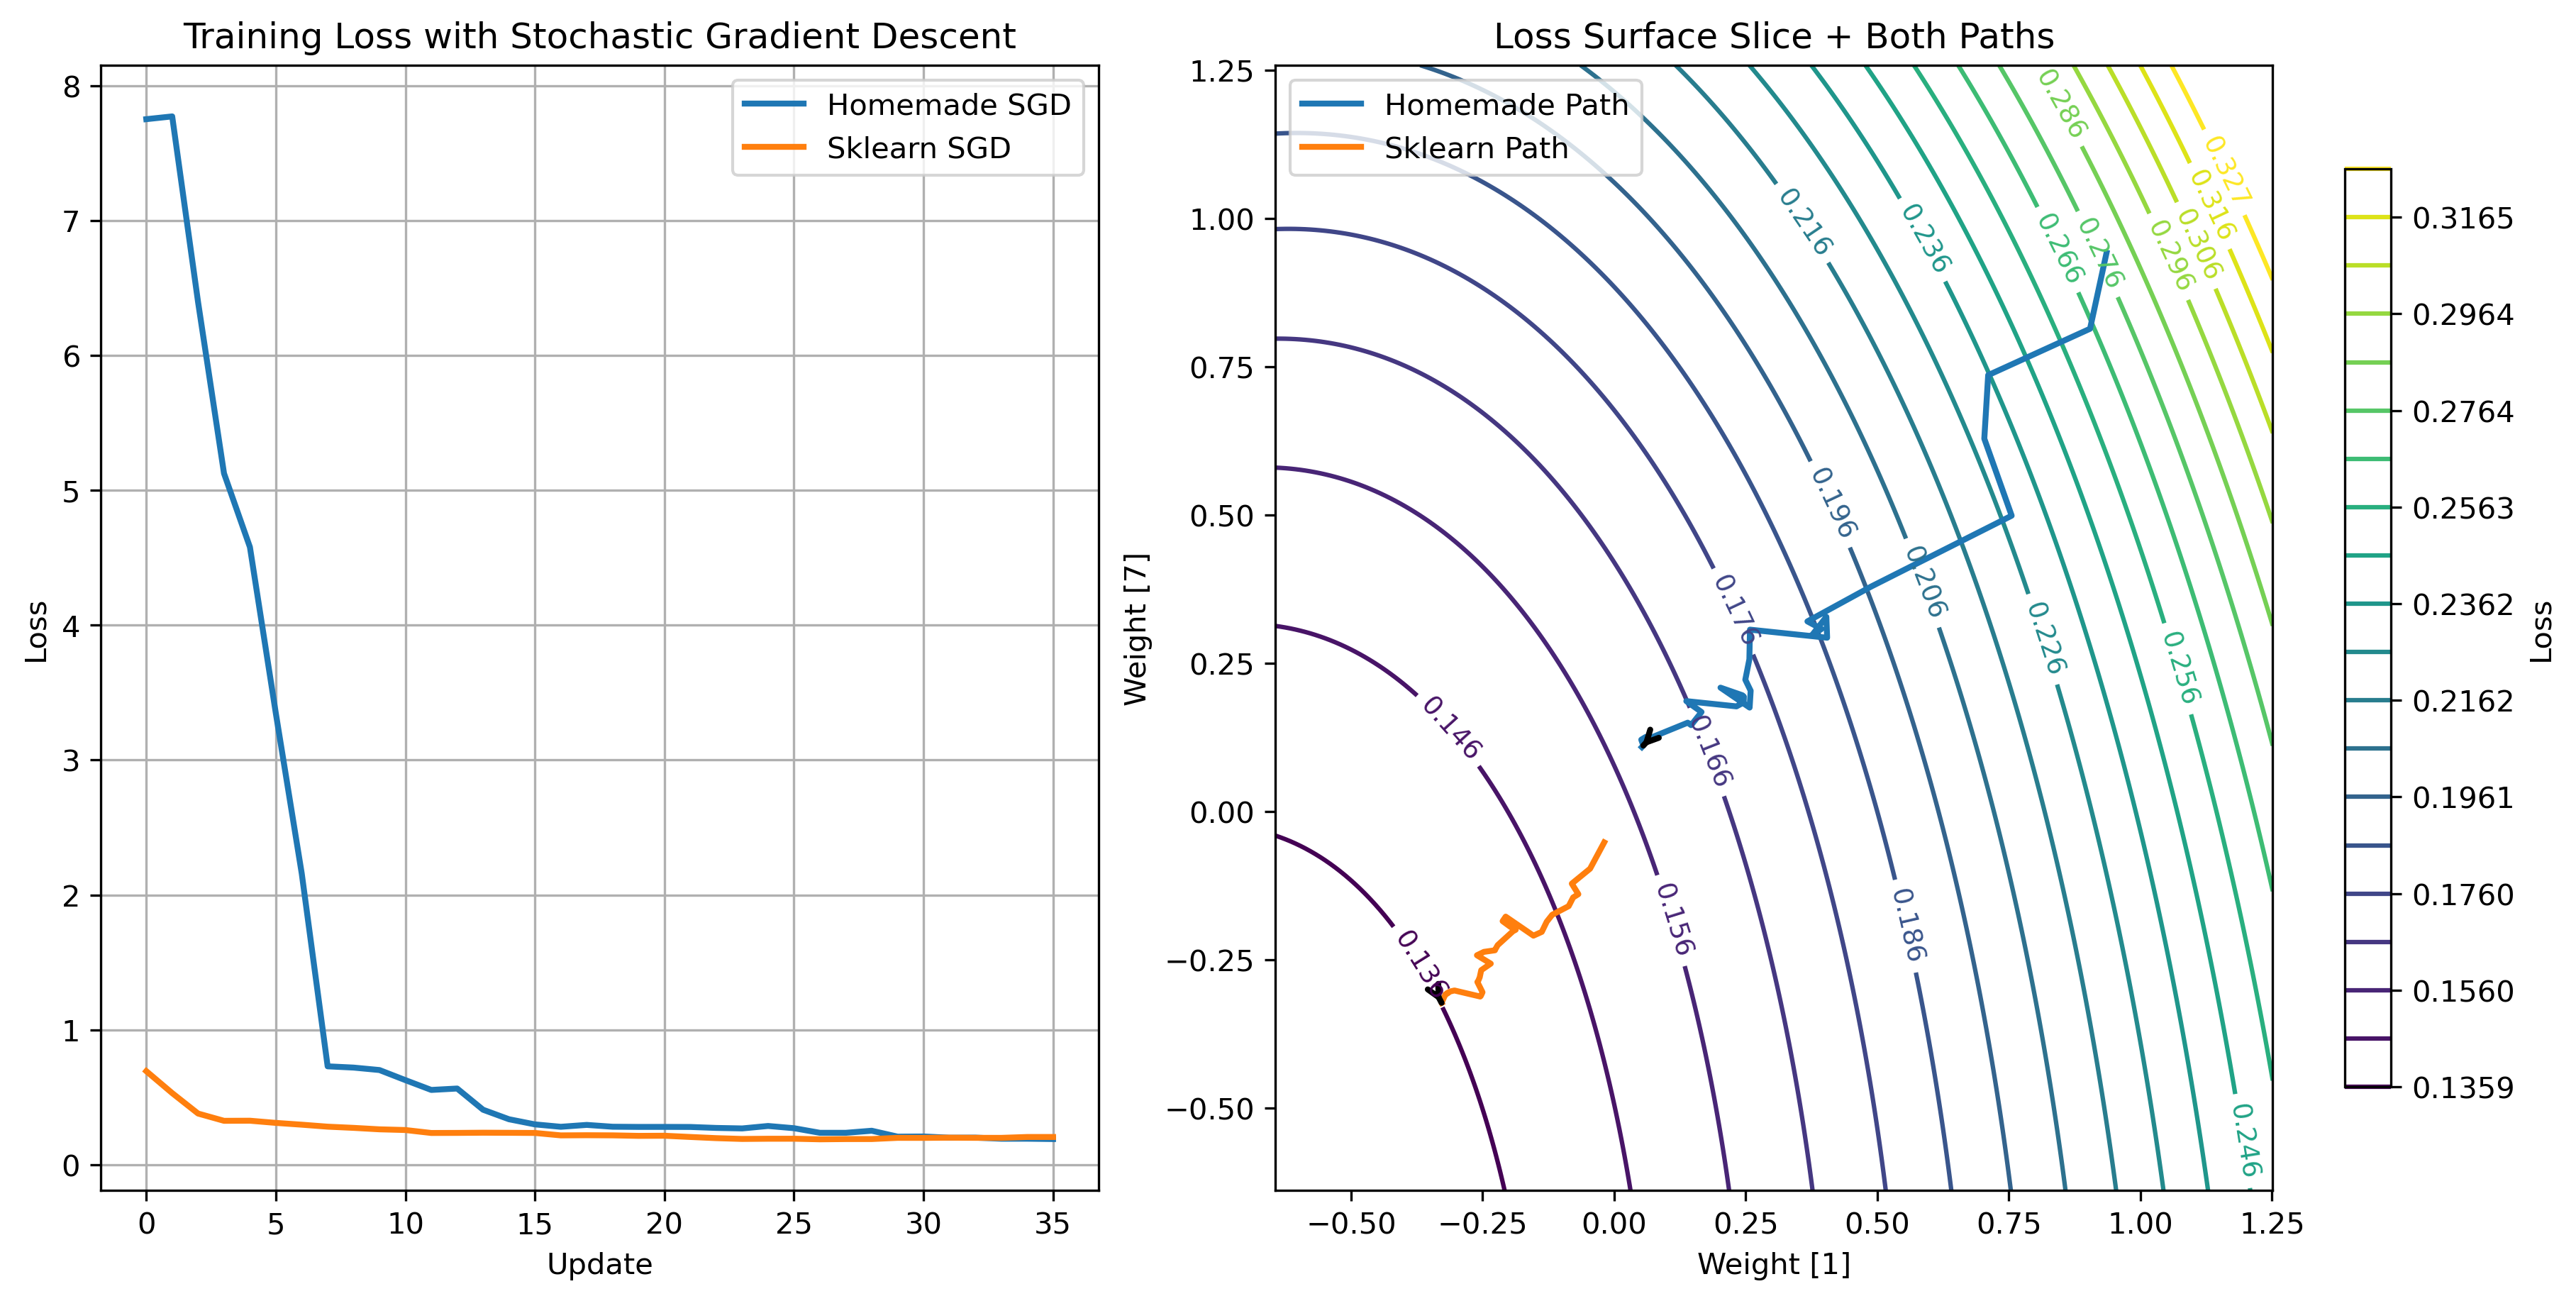

In [8]:
def stack(seq, name):
    """
    Stack a list of paramater vectors into a 2D array.
    """
    
    if len(seq) == 0:
        raise ValueError(f"{name} is empty — did you forget to append weights each step?")
    arr = np.stack(seq, axis=0)  # shape: (steps, d)
    
    if arr.ndim != 2 or arr.shape[1] == 0:
        raise ValueError(f"{name} has wrong shape {arr.shape}.")
    
    return arr


w_path_home = stack(history["weights"],  "history['weights']")
w_path_sgd  = stack(history_sgd["weights"], "history_sgd['weights']")
b_path_home = np.asarray(history["intercept"], dtype=float)
b_path_sgd  = np.asarray(history_sgd["intercept"], dtype=float)

# Choose slice indices by movement across BOTH paths
# Just because it has the largest movement doesn't mean it is guaranteed to reach the minima of the slice
w_all = np.vstack([w_path_home, w_path_sgd])
movement = w_all.max(axis=0) - w_all.min(axis=0)
j, k = np.argsort(movement)[-2:]

wj_home, wk_home = w_path_home[:, j], w_path_home[:, k]
wj_sgd,  wk_sgd  = w_path_sgd[:, j],  w_path_sgd[:, k]

def _pad(lo, hi, frac=0.25, min_span=1e-3):
    """
    Pad [lo, hi] by a fraction so contours don't clip the trajectories
    """
    
    span = max(hi - lo, min_span); pad = frac * span
    
    return lo - pad, hi + pad


wj_lo, wj_hi = _pad(min(wj_home.min(), wj_sgd.min()), max(wj_home.max(), wj_sgd.max()))
wk_lo, wk_hi = _pad(min(wk_home.min(), wk_sgd.min()), max(wk_home.max(), wk_sgd.max()))

# Freeze other dims at average of final weights to be neutral
w_ref = 0.5 * (w_path_home[-1] + w_path_sgd[-1])
b_ref = 0.5 * (b_path_home[-1] + b_path_sgd[-1])

N = 201 # Grid resolution for loss-surface slice
wj, wk = np.meshgrid(np.linspace(wj_lo, wj_hi, N),
                     np.linspace(wk_lo, wk_hi, N))
j_grid = np.empty_like(wj, dtype=float)
for r in range(N):
    for c in range(N):
        w_tmp = w_ref.copy()
        w_tmp[j] = wj[r, c]
        w_tmp[k] = wk[r, c]
        j_grid[r, c] = loss(X_train, y_train, w_tmp, b_ref, L2)

levels = np.linspace(np.percentile(j_grid, 5), np.percentile(j_grid, 99), 20)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Left: loss curves
ax[0].plot(history["loss"], lw=2, label="Homemade SGD", alpha=1)
ax[0].plot(history_sgd["loss"], lw=2, label="Sklearn SGD", alpha=1)
ax[0].set_title("Training Loss with Stochastic Gradient Descent"); ax[0].set_xlabel("Update"); ax[0].set_ylabel("Loss")
ax[0].grid(alpha=1); ax[0].legend()

# Right: contour of two weights + both trajectories (line + single arrow showing end point)
cs = ax[1].contour(wj, wk, j_grid, levels=levels, cmap="viridis", alpha=1)
ax[1].clabel(cs, fmt="%.3f", inline=True, fontsize=9)

ax[1].plot(wj_home, wk_home, lw=2, label="Homemade Path")
if len(wj_home) >= 2:
    ax[1].annotate("", xy=(wj_home[-1], wk_home[-1]), xytext=(wj_home[-2], wk_home[-2]),
                   arrowprops=dict(arrowstyle="->", lw=2))

ax[1].plot(wj_sgd, wk_sgd, lw=2, label="Sklearn Path")
if len(wj_sgd) >= 2:
    ax[1].annotate("", xy=(wj_sgd[-1], wk_sgd[-1]), xytext=(wj_sgd[-2], wk_sgd[-2]),
                   arrowprops=dict(arrowstyle="->",  lw=2))

ax[1].set_xlabel(f"Weight [{j}]"); ax[1].set_ylabel(f"Weight [{k}]")
ax[1].set_title("Loss Surface Slice + Both Paths")
ax[1].legend(loc="best")
fig.colorbar(cs, ax=ax[1], fraction=0.046, pad=0.04, label="Loss")
plt.show()

##### Comparison of homemade vs built-in SGD. The Scikit-learn path seems to show a better minimisation with right contour plot, but this is only a comparision of two variables, compared to the multiple variables within the dataset. The code picks the path of optimisation that had the largest change for the homemade descent and shows that.

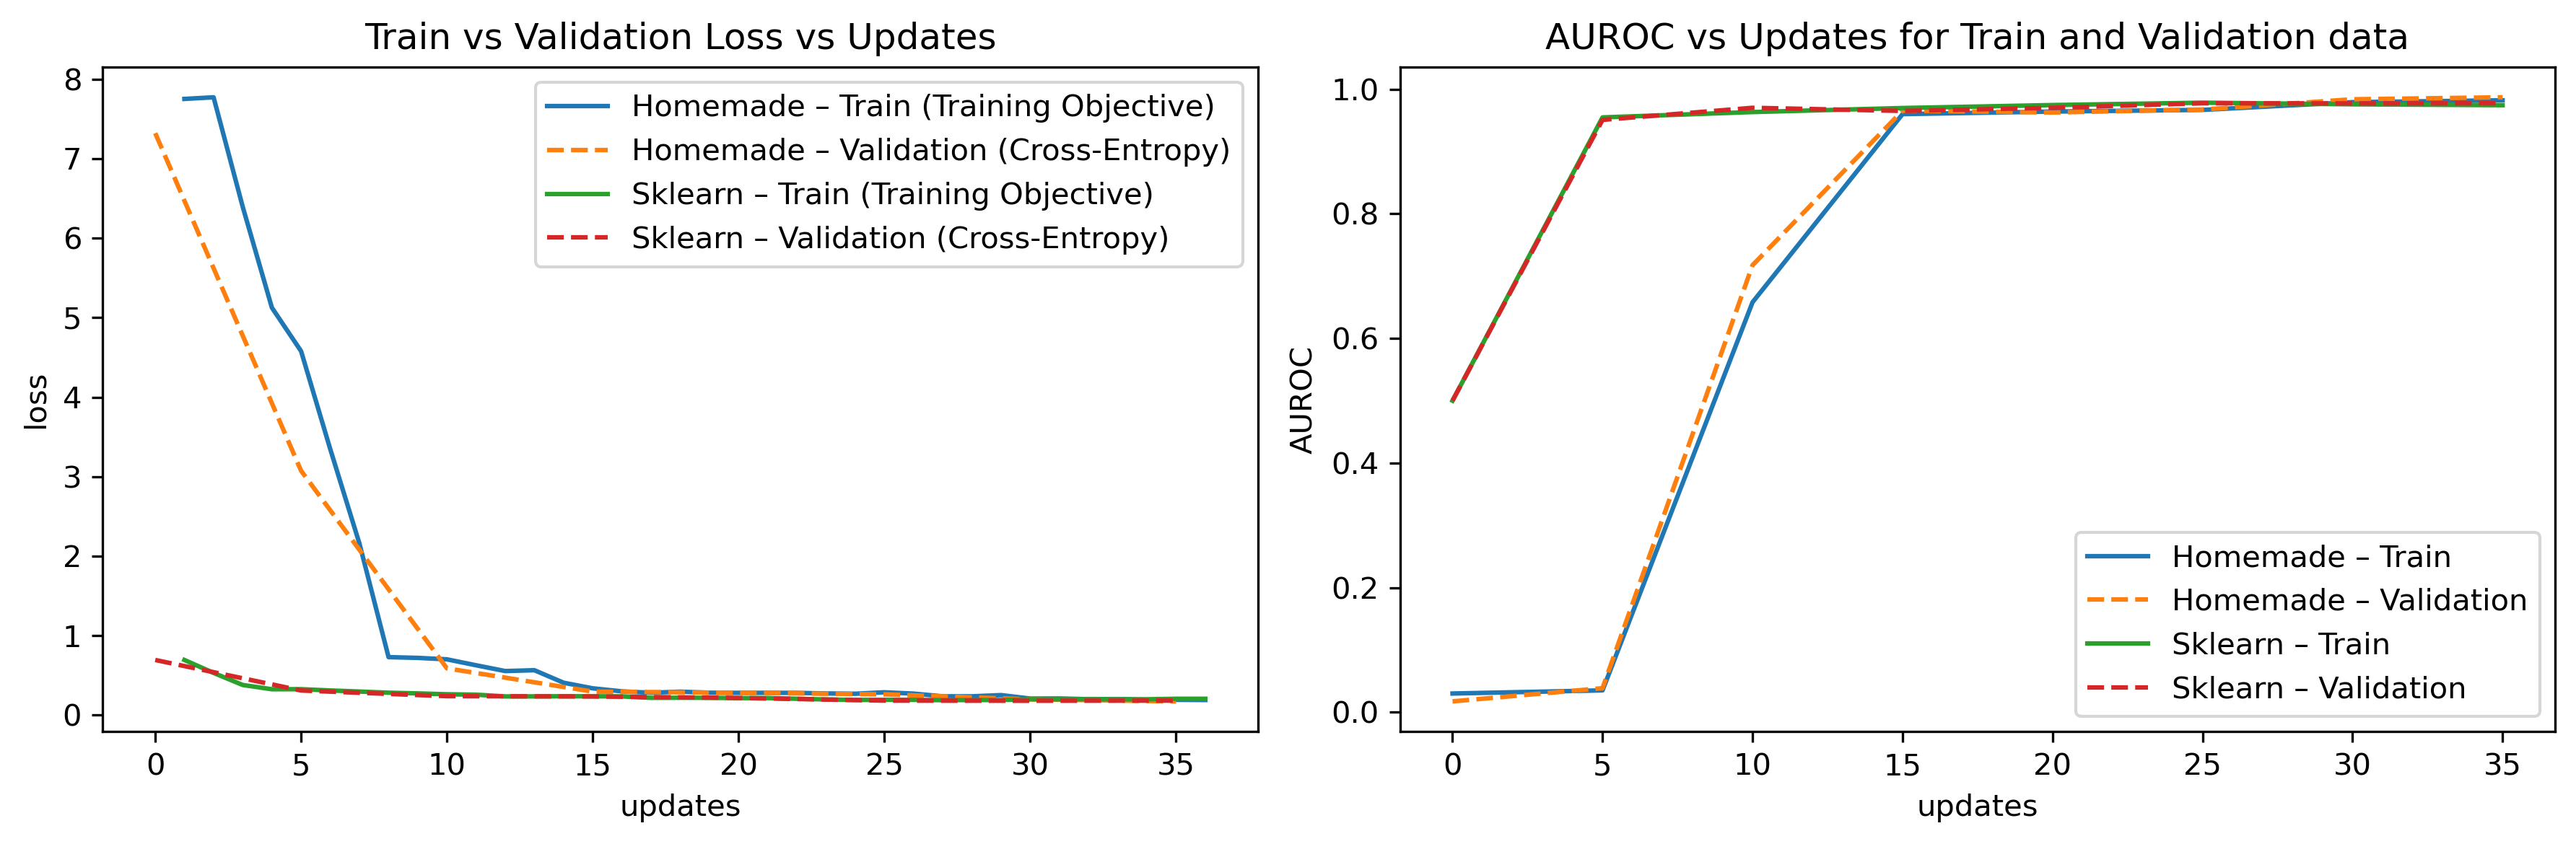

In [9]:
# Build x-axes by tracking steps
steps_home_train = np.arange(1, len(history["loss"])+1)
steps_home_eval  = np.asarray(history["steps_eval"])

steps_sgd_train  = np.arange(1, len(history_sgd["loss"])+1)
steps_sgd_eval   = np.asarray(history_sgd["steps_eval"])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Left: loss vs. steps
ax[0].plot(steps_home_train, history["loss"],                 label="Homemade – Train (Training Objective)")
ax[0].plot(steps_home_eval,  history["loss_val"],  "--",      label="Homemade – Validation (Cross-Entropy)")

ax[0].plot(steps_sgd_train,  history_sgd["loss"],             label="Sklearn – Train (Training Objective)")
ax[0].plot(steps_sgd_eval,   history_sgd["loss_val"],  "--",  label="Sklearn – Validation (Cross-Entropy)")

ax[0].set_xlabel("updates"); ax[0].set_ylabel("loss")
ax[0].set_title("Train vs Validation Loss vs Updates")
ax[0].legend(loc="best")

# Right: AUROC vs. steps
ax[1].plot(steps_home_eval, history["auroc_train"],           label="Homemade – Train")
ax[1].plot(steps_home_eval, history["auroc_val"],   "--",     label="Homemade – Validation") 

ax[1].plot(steps_sgd_eval,  history_sgd["auroc_train"],       label="Sklearn – Train")
ax[1].plot(steps_sgd_eval,  history_sgd["auroc_val"],  "--",  label="Sklearn – Validation")

ax[1].set_xlabel("updates"); ax[1].set_ylabel("AUROC")
ax[1].set_title("AUROC vs Updates for Train and Validation data")
ax[1].legend(loc="lower right")

plt.tight_layout(); plt.show()

In [10]:
# Sklearn validation scores
pos_idx = int(np.where(sgd_clf.classes_ == 1)[0][0])
val_proba_sgd = sgd_clf.predict_proba(X_val)[:, pos_idx]

best_threshold_sgd, _ = best_threshold_f1(y_val, val_proba_sgd)

proba_home_test = sigmoid(X_test, w, b)
pred_home_test  = (proba_home_test >= best_threshold_homemade).astype(int)

# Best F1 thresholds
pos_idx = int(np.where(sgd_clf.classes_ == 1)[0][0])
proba_sgd_test = sgd_clf.predict_proba(X_test)[:, pos_idx]
pred_sgd_test  = (proba_sgd_test >= best_threshold_sgd).astype(int)

# Print metrics
evaluate(y_test, pred_home_test, proba_home_test, "Homemade SGD (test):")
evaluate(y_test, pred_sgd_test,  proba_sgd_test,  "Sklearn SGD (test):")


Homemade SGD (test):
accuracy  : 0.9474
precision : 0.9583   recall: 0.9583   f1: 0.9583
AUROC     : 0.9894
log loss  : 0.1815
brier: 0.0488
confusion :
 [[39  3]
 [ 3 69]]

Sklearn SGD (test):
accuracy  : 0.8684
precision : 0.9672   recall: 0.8194   f1: 0.8872
AUROC     : 0.9792
log loss  : 0.2205
brier: 0.0708
confusion :
 [[40  2]
 [13 59]]


##### It can be seen that the homemade SGD performs the same, if not better than the built-in SGD function, showing that it works well and was made correctly.

### Key takeaways

- Gradient descent iteratively minimises a loss by following its negative gradient.
- The learning rate strongly influences convergence speed and stability.
- Visualising parameter trajectories and loss curves is essential for diagnosing optimisation behaviour.
- Simple toy problems reveal optimisation dynamics that also apply to large-scale models.